Check working directory.

In [6]:
#Package
import os

#Command
os.getcwd()

'/home/howsetya/workspace/Bioimage2'

There are 4 directories of data, namely 2 sets of training and 2 sets of challenge datasets with the following relative path:
1. ./Images/training_BF-C2DL-HSC/01/subset/*.tif
2. ./Images/training_BF-C2DL-HSC/02/subset/*.tif
3. ./Images/challenge_BF-C2DL-HSC/01/subset/*.tif
4. ./Images/challenge_BF-C2DL-HSC/02/subset/*.tif

These are all subsets of the real complete dataset to save time in going through all the data. Each contains around 20% the amount of the complete data (0.2 * ~1700 = ~350 images).

Additionally, the training 01 dataset is further subset to get an even fewer images in the path
./Images/training_BF-C2DL-HSC/01/subset2/*.tif

First, define a function to load image files and put them in a data frame.

In [7]:
#Package
import glob, re
import pandas as pd
from skimage.io import imread, imshow, show

#Function
def load_imgs(path):
    files_img = glob.glob(path)
    files_img.sort()
    df_img = pd.DataFrame(columns=['FileName','Image'])
    for file in files_img:
        filename = re.sub(".*/", "", file[:-4])
        img = imread(file) #tifffile plugin for loading compressed tiffs requires imagecodecs
        df_img.loc[len(df_img)] = [filename,img]
        # print(file) #to show progress
        # imshow(img) #to show image
        # show()
    return(df_img)

In [8]:
#Set path
#This subset2 folder contains even fewer images than the one mentioned above 
path = ('./Images/training_BF-C2DL-HSC/01/subset2/*.tif')

#Load all images in the directory of the path
train1_subs2 = load_imgs(path)

In [9]:
#Check the data frame
train1_subs2.shape

(27, 2)

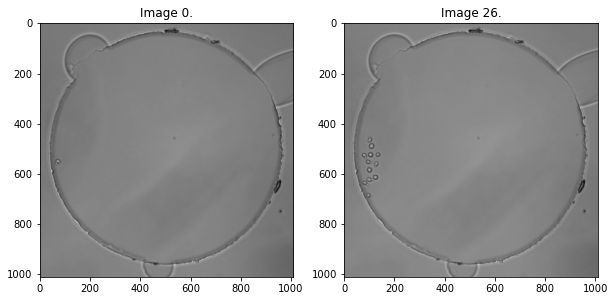

In [10]:
#Package
import matplotlib.pyplot as plt

#Check the images
n1 = 0 # first image
n2 = 26 # last image
fig, ax = plt.subplots(1,2,figsize=(10,10))
ax[0].imshow(train1_subs2.iloc[n1,1],cmap='gray')
ax[0].set_title(f'Image {n1}.')
ax[1].imshow(train1_subs2.iloc[n2,1],cmap='gray')
ax[1].set_title(f'Image {n2}.')
plt.show()

Just to get an idea of how the images of the other sets look like, one arbitrary image is taken from each directory and plotted.

In [11]:
#Load just one image from each directory.
tr1_ss = imread('./Images/training_BF-C2DL-HSC/01/subset/t1700.tif')
tr2_ss = imread('./Images/training_BF-C2DL-HSC/02/subset/t1700.tif')
ch1_ss = imread('./Images/challenge_BF-C2DL-HSC/01/subset/t1700.tif')
ch2_ss = imread('./Images/challenge_BF-C2DL-HSC/02/subset/t1700.tif')

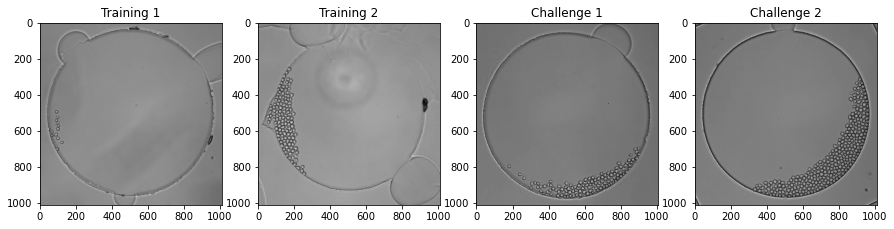

In [12]:
#Check the image
fig, ax = plt.subplots(1,4, figsize=(15,15))
ax[0].imshow(tr1_ss,cmap='gray')
ax[0].set_title('Training 1')
ax[1].imshow(tr2_ss,cmap='gray')
ax[1].set_title('Training 2')
ax[2].imshow(ch1_ss,cmap='gray')
ax[2].set_title('Challenge 1')
ax[3].imshow(ch2_ss,cmap='gray')
ax[3].set_title('Challenge 2')
plt.show()

As can be seen intuitively here, the images lack contrast, clearly demonstrated by the dominating grey colour over all the images from the background up to the cells themselves. The histogram also indicate the difficulty that would be encountered should a manual thresholding is to be done.

Another note, the wells seems to be nicely rounded except for one dataset (Training2).

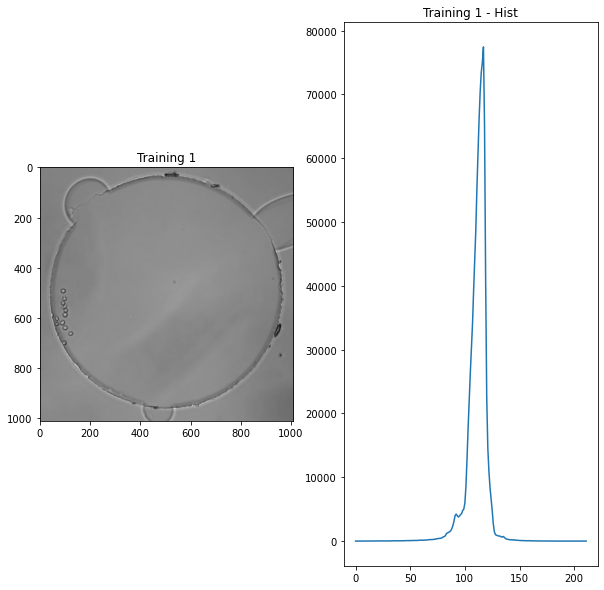

In [13]:
#Package
from skimage import exposure

hist, hist_centers = exposure.histogram(tr1_ss)

#Plot
fig, ax = plt.subplots(1,2,figsize=(10,10))
ax[0].imshow(tr1_ss,cmap='gray')
ax[0].set_title('Training 1')
ax[1].plot(hist)
ax[1].set_title('Training 1 - Hist')
plt.show()

Efforts to improve contrast are therefore attempted by automatic thresholding using different methods available in skimage.

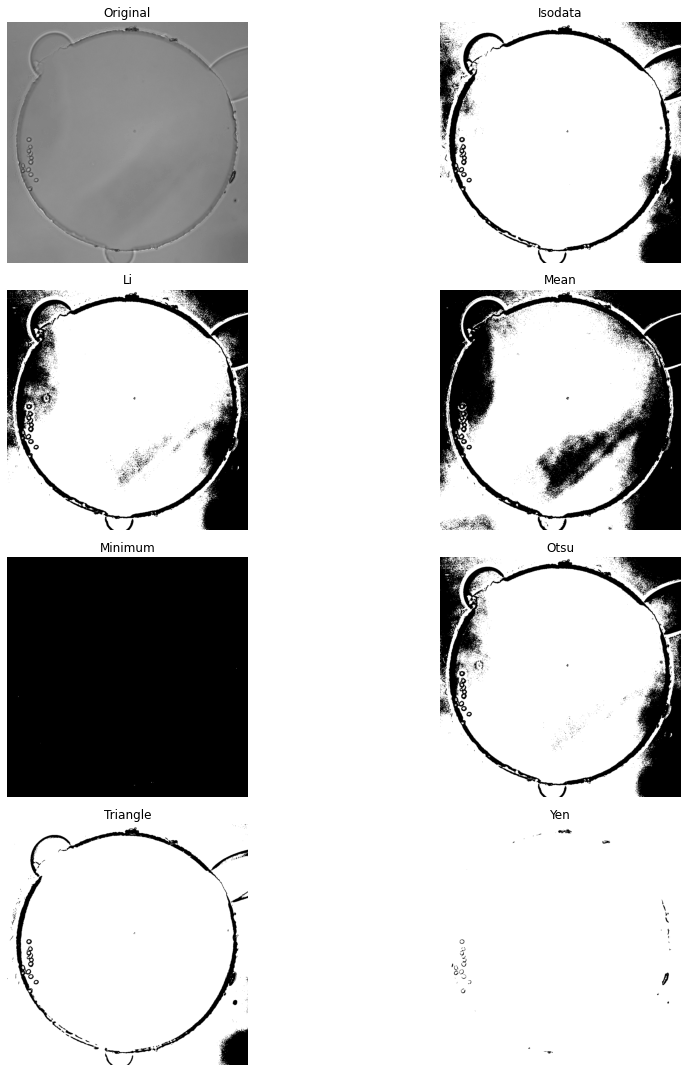

In [14]:
#Package
from skimage.filters import try_all_threshold

#Plot
fig, ax = try_all_threshold(tr1_ss, figsize=(15, 15), verbose=False)
plt.show()

The Triangle and Yen thresholding method seems promising, at least for the one arbitrary example here.

The Triangle method is then tried to the small subset that has been loaded before (train1_subs2).

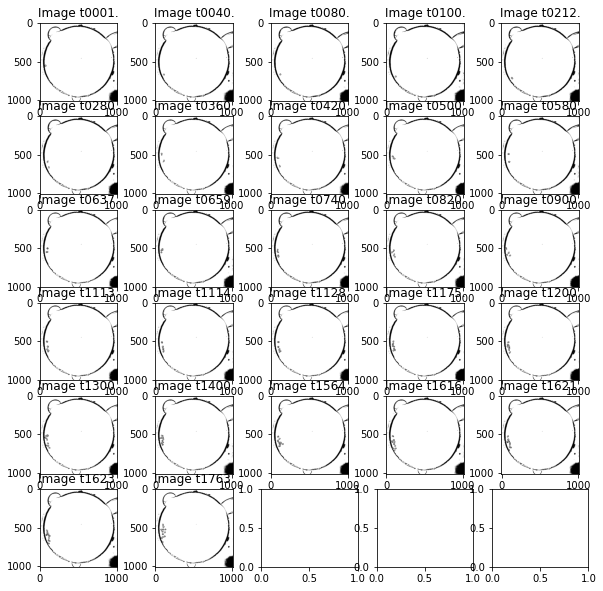

In [15]:
#Package
from skimage.filters import threshold_triangle as tri

fig, ax = plt.subplots(6,5,figsize=(10,10))
ax = ax.ravel()
for n in range(len(train1_subs2)):
    thr = tri(train1_subs2.iloc[n,1]) 
    binary_img = train1_subs2.iloc[n,1] > thr
    title = train1_subs2.iloc[n,0]
    ax[n].imshow(binary_img, cmap='gray')
    ax[n].set_title(f'Image {title}.')
    
#Alternatively, larger images
#for n in range(len(train1_subs2)):
#    thr = tri(train1_subs2.iloc[n,1]) 
#    binary_img = train1_subs2.iloc[n,1] > thr
#    fig, ax = plt.subplots(figsize=(8,8))
#    plt.imshow(binary_img, cmap='gray')
#    show()

Now, try the Yen method.

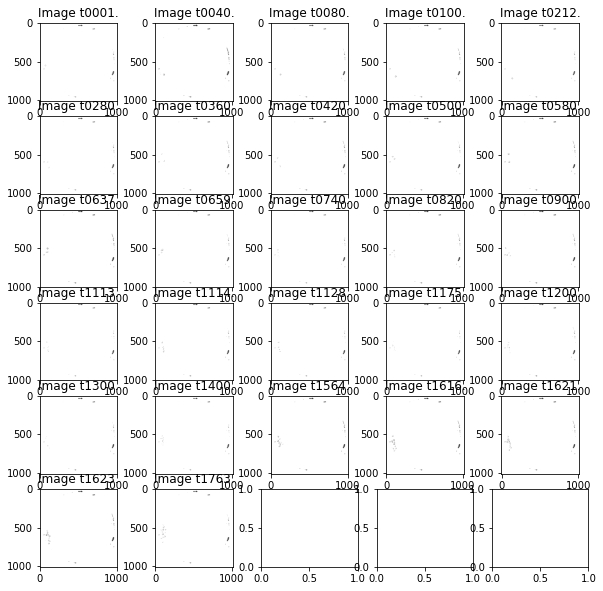

In [16]:
#Package
from skimage.filters import threshold_yen as yen

fig, ax = plt.subplots(6,5,figsize=(10,10))
ax = ax.ravel()
for n in range(len(train1_subs2)):
    thr = yen(train1_subs2.iloc[n,1]) 
    binary_img = train1_subs2.iloc[n,1] > thr
    title = train1_subs2.iloc[n,0]
    ax[n].imshow(binary_img, cmap='gray')
    ax[n].set_title(f'Image {title}.')
    
#Alternatively, larger images
#for n in range(len(train1_subs2)):
#    thr = tri(train1_subs2.iloc[n,1]) 
#    binary_img = train1_subs2.iloc[n,1] > thr
#    fig, ax = plt.subplots(figsize=(8,8))
#    plt.imshow(binary_img, cmap='gray')
#    show()

To remove the outlines of the well where the cells proliferate, a mask is manually made for the well in each dataset. All the wells looks well rounded and only ever so slightly off-center. So a simple circle masking would work for all dataset except for the Training 2 dataset. Nevertheless, a bespoke masking option might as well be available for other datasets.

In [21]:
#Package
import numpy as np
from skimage import draw

#Function
def mask_set(image_arr,set=''):
    mask = np.ones(shape=image_arr.shape[0:2], dtype="bool")
    if set == 'tr1': #for training 1 dataset
        rr, cc = draw.disk((500, 500), 460)
        mask[rr, cc] = False
    elif set == 'tr2': #for training 2 dataset
        #rr, cc = draw.polygon((560,328,766),(25,117,178))
        rr, cc = draw.ellipse(455,168,80,180,rotation=np.deg2rad(45)) # better than polygon
        mask[rr, cc] = False
        rr1, cc1 = draw.disk((500, 500), 420)
        mask[rr1,cc1] =False
    elif set == 'ch1': #for challenge 1 dataset
        rr, cc = draw.disk((510, 505), 465)
        mask[rr, cc] = False
    elif set == 'ch2': #for challenge 2 dataset
        rr, cc = draw.disk((505, 500), 470)
        mask[rr, cc] = False
    else:
        print('Specify set (tr1, tr2, ch1, or ch2).')
    image_arr[mask] = 0
    return(image_arr)

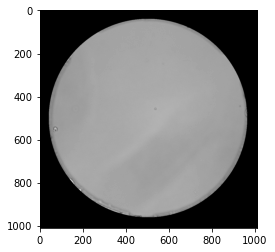

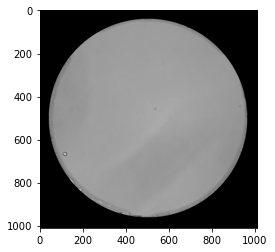

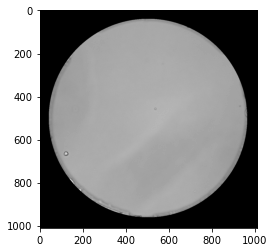

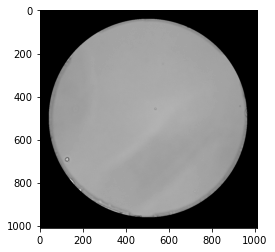

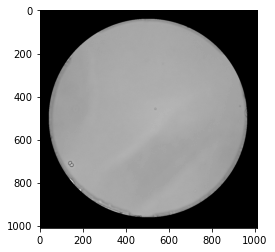

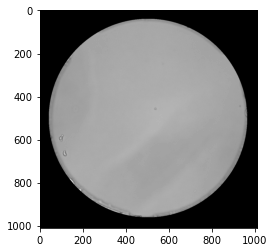

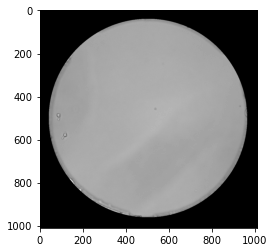

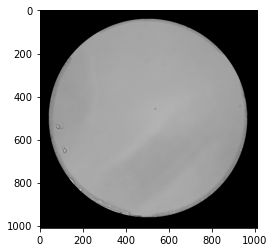

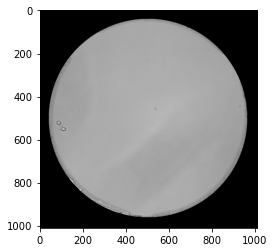

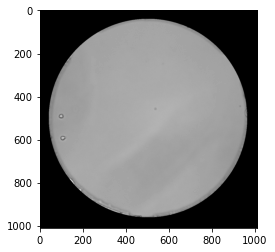

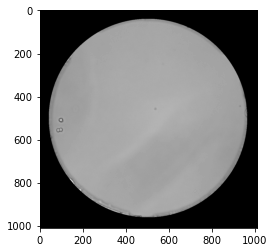

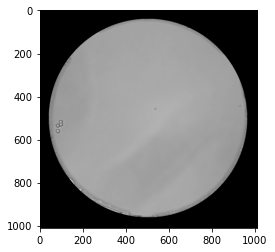

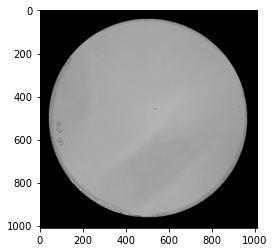

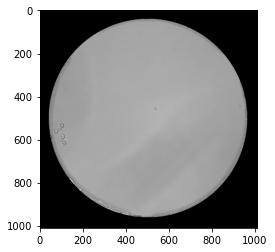

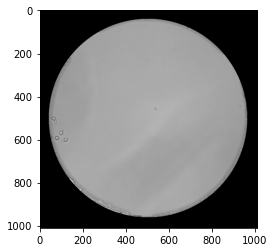

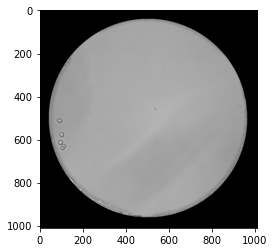

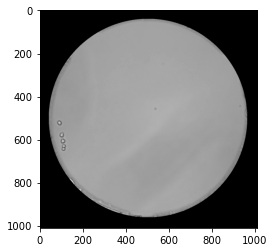

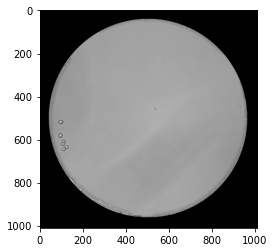

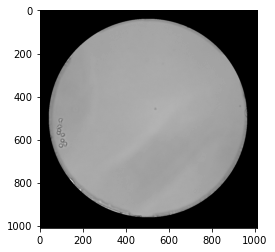

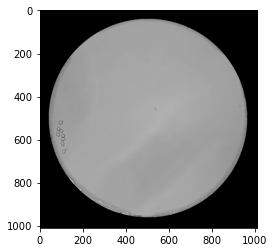

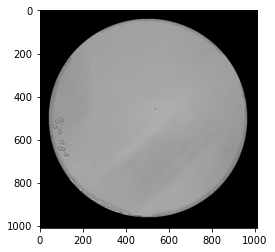

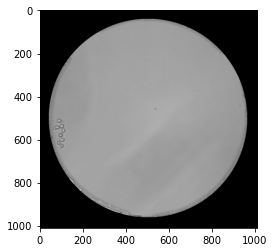

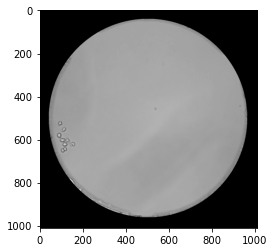

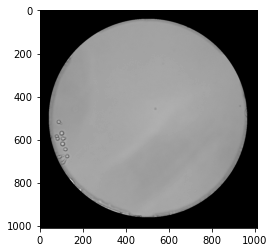

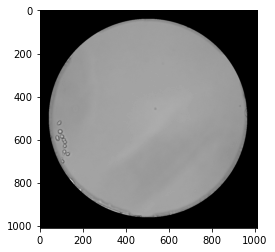

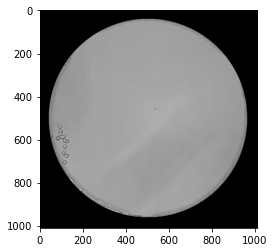

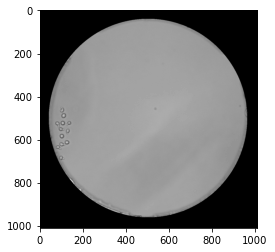

In [22]:
#Apply masking
for n in range(len(train1_subs2)):
    image_arr = train1_subs2.iloc[n,1]
    masked = mask_set(image_arr,set='tr1') #Change set accordingly 
    plt.imshow(masked,cmap='gray')
    show()